In [7]:
import re
import os
import random

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
import plotly.express as px

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

In [8]:
plt.style.available

['Solarize_Light2',
 '_classic_test_patch',
 '_mpl-gallery',
 '_mpl-gallery-nogrid',
 'bmh',
 'classic',
 'dark_background',
 'fast',
 'fivethirtyeight',
 'ggplot',
 'grayscale',
 'seaborn-v0_8',
 'seaborn-v0_8-bright',
 'seaborn-v0_8-colorblind',
 'seaborn-v0_8-dark',
 'seaborn-v0_8-dark-palette',
 'seaborn-v0_8-darkgrid',
 'seaborn-v0_8-deep',
 'seaborn-v0_8-muted',
 'seaborn-v0_8-notebook',
 'seaborn-v0_8-paper',
 'seaborn-v0_8-pastel',
 'seaborn-v0_8-poster',
 'seaborn-v0_8-talk',
 'seaborn-v0_8-ticks',
 'seaborn-v0_8-white',
 'seaborn-v0_8-whitegrid',
 'tableau-colorblind10']

In [9]:
plt.style.use('seaborn-v0_8')


In [10]:
import torch
import torchtext
from torchtext import data, datasets
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data
from torch.utils.data import TensorDataset, DataLoader
import torch.optim as optim

import transformers
from transformers import BertTokenizer, BertModel, BertConfig

import tokenizers

import nltk
from nltk.stem import SnowballStemmer
from nltk.stem import WordNetLemmatizer
from wordcloud import WordCloud
from PIL import Image

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split

In [12]:
USE_CUDA = torch.cuda.is_available() 
print(USE_CUDA)

True


In [13]:
#nltk.download('stopwords')
from nltk.corpus import stopwords
stop_words = stopwords.words('english')

In [14]:
train_df = pd.read_csv('./input/train.csv')
test_df = pd.read_csv('./input/test.csv')
train_df.head()

,textID,text,selected_text,sentiment
0,cb774db0d1,"I`d have responded, if I were going","I`d have responded, if I were going",neutral
1,549e992a42,Sooo SAD I will miss you here in San Diego!!!,Sooo SAD,negative
2,088c60f138,my boss is bullying me...,bullying me,negative
3,9642c003ef,what interview! leave me alone,leave me alone,negative
4,358bd9e861,"Sons of ****, why couldn`t they put them on t...","Sons of ****,",negative


In [15]:
print("Train data size : {}".format(train_df.shape))
print("Test data size : {}".format(test_df.shape))

Train data size : (27481, 4)
Test data size : (3534, 3)


In [16]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27481 entries, 0 to 27480
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   textID         27481 non-null  object
 1   text           27480 non-null  object
 2   selected_text  27480 non-null  object
 3   sentiment      27481 non-null  object
dtypes: object(4)
memory usage: 858.9+ KB


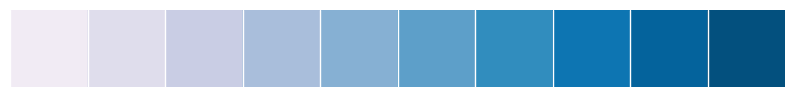

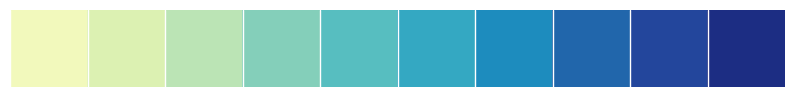

In [17]:
PuBu_palette = sns.color_palette("PuBu", 10)
YlGnBu_palette = sns.color_palette("YlGnBu", 10)
sns.palplot(PuBu_palette)
sns.palplot(YlGnBu_palette)

In [18]:
pd.DataFrame(train_df.isnull().sum(), columns=["Train Null Count"])

,Train Null Count
textID,0
text,1
selected_text,1
sentiment,0


In [19]:
pd.DataFrame(test_df.isnull().sum(), columns=["Test Null Count"])

,Test Null Count
textID,0
text,0
sentiment,0


<Axes: >

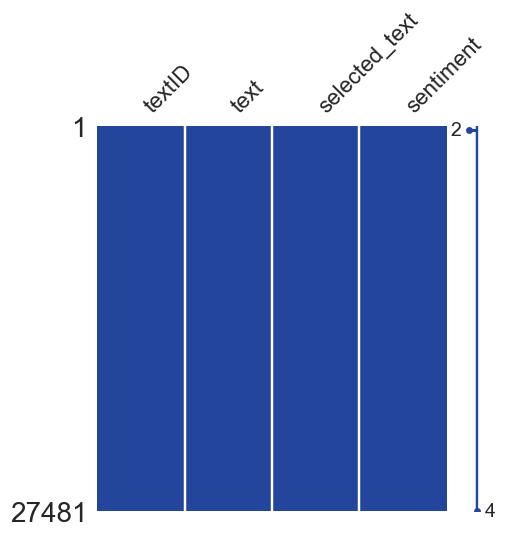

In [20]:
msno.matrix(df=train_df.iloc[:,:],figsize=(5,5),color=YlGnBu_palette[8])

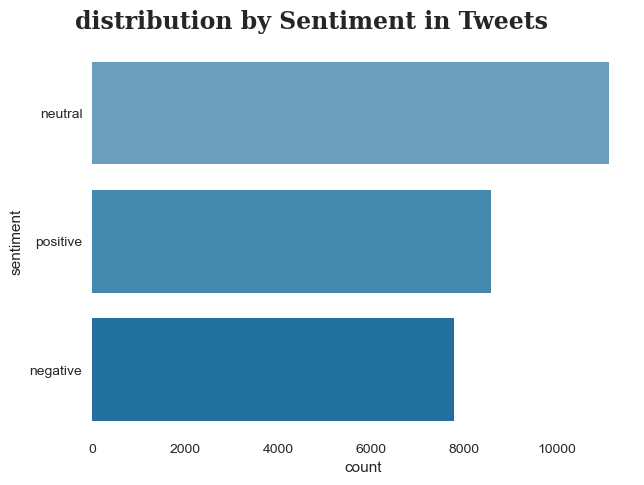

In [21]:
fig, ax = plt.subplots(1,1,figsize=(7, 5))
ax = sns.countplot(train_df["sentiment"].sort_values(ascending=False),
              order = train_df['sentiment'].value_counts().index,
              palette=PuBu_palette[-5:])
ax.patch.set_alpha(0)
fig.text(0.1,0.92,"distribution by Sentiment in Tweets", fontweight="bold", fontfamily='serif', fontsize=17)
plt.show()

In [22]:
def get_length_alphabets(text):
    text = str(text)
    return len(text)

In [23]:
def get_length_words(text):
    text = str(text)
    return len(text.split(' '))

In [24]:
train_df['length_alphabets'] = train_df['text'].apply(lambda x: get_length_alphabets(x))
train_df['length_words'] = train_df['text'].apply(lambda x: get_length_words(x))
train_df.head()

,textID,text,selected_text,sentiment,length_alphabets,length_words
0,cb774db0d1,"I`d have responded, if I were going","I`d have responded, if I were going",neutral,36,8
1,549e992a42,Sooo SAD I will miss you here in San Diego!!!,Sooo SAD,negative,46,11
2,088c60f138,my boss is bullying me...,bullying me,negative,25,5
3,9642c003ef,what interview! leave me alone,leave me alone,negative,31,6
4,358bd9e861,"Sons of ****, why couldn`t they put them on t...","Sons of ****,",negative,75,15


In [25]:
train_df.describe()

,length_alphabets,length_words
count,27481.000000,27481.000000
mean,68.327645,13.779448
std,35.605403,7.169974
min,3.000000,1.000000
25%,39.000000,8.000000
50%,64.000000,13.000000
75%,97.000000,19.000000
max,141.000000,101.000000


In [26]:
PuBu_palette

[(0.946236063052672, 0.9233525567089581, 0.9588465974625143),
 (0.8768319876970396, 0.8676509034986544, 0.928166089965398),
 (0.788558246828143, 0.8066897347174163, 0.8948558246828143),
 (0.6645444059976933, 0.7476355247981545, 0.8623760092272202),
 (0.5256439830834294, 0.691041906958862, 0.8287427912341407),
 (0.36718185313341023, 0.6273740868896578, 0.7905420991926182),
 (0.19594002306805075, 0.5543713956170704, 0.7477739331026528),
 (0.05125720876585929, 0.4598846597462514, 0.7005305651672433),
 (0.017424067666282197, 0.39117262591311036, 0.613763936947328),
 (0.013502499038831219, 0.3158169934640523, 0.4950711264898116)]

In [27]:
three_PuBu_palette = list()
three_PuBu_palette.append(PuBu_palette[2])
three_PuBu_palette.append(PuBu_palette[6])
three_PuBu_palette.append(PuBu_palette[4])
three_PuBu_palette

[(0.788558246828143, 0.8066897347174163, 0.8948558246828143),
 (0.19594002306805075, 0.5543713956170704, 0.7477739331026528),
 (0.5256439830834294, 0.691041906958862, 0.8287427912341407)]

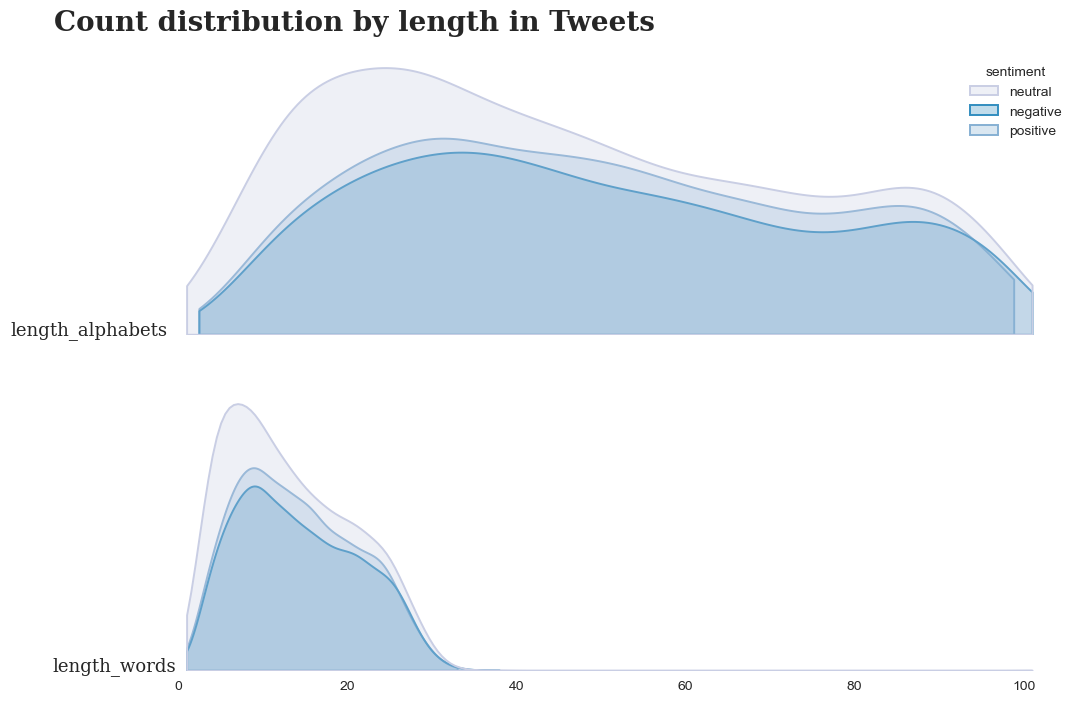

In [28]:
fig = plt.figure(figsize=(12, 8))
gs = fig.add_gridspec(2,1)

axes = list()

for index, data in zip(range(2), train_df):
    axes.append(fig.add_subplot(gs[index, 0]))
    
    
    if index==0:
        sns.kdeplot(x='length_alphabets', data=train_df, 
                        fill=True, ax=axes[index], cut=0, bw_method=0.20, 
                        lw=1.4 , hue='sentiment', palette=three_PuBu_palette,
                         alpha=0.3)
    else:
        sns.kdeplot(x='length_words', data=train_df, 
                    fill=True, ax=axes[index], cut=0, bw_method=0.20, 
                    lw=1.4 , hue='sentiment',palette=three_PuBu_palette,
                     alpha=0.3) 

    axes[index].set_yticks([])
    if index != 1 : axes[index].set_xticks([])
    axes[index].set_ylabel('')
    axes[index].set_xlabel('')
    axes[index].spines[["top","right","left","bottom"]].set_visible(False)
    
    
    if index == 0:
        axes[index].text(-0.2,0,"length_alphabets",fontweight="light", fontfamily='serif', fontsize=13,ha="right")
    else:
        axes[index].text(-0.2,0,"length_words",fontweight="light", fontfamily='serif', fontsize=13,ha="right")
        
        
    axes[index].patch.set_alpha(0)
    if index != 0 : axes[index].get_legend().remove()
        
fig.text(0.05,0.91,"Count distribution by length in Tweets", fontweight="bold", fontfamily='serif', fontsize=20)
plt.show()

In [29]:
def get_top_tweet_bigrams(corpus, n=None):
    vec = CountVectorizer(ngram_range=(2, 2)).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

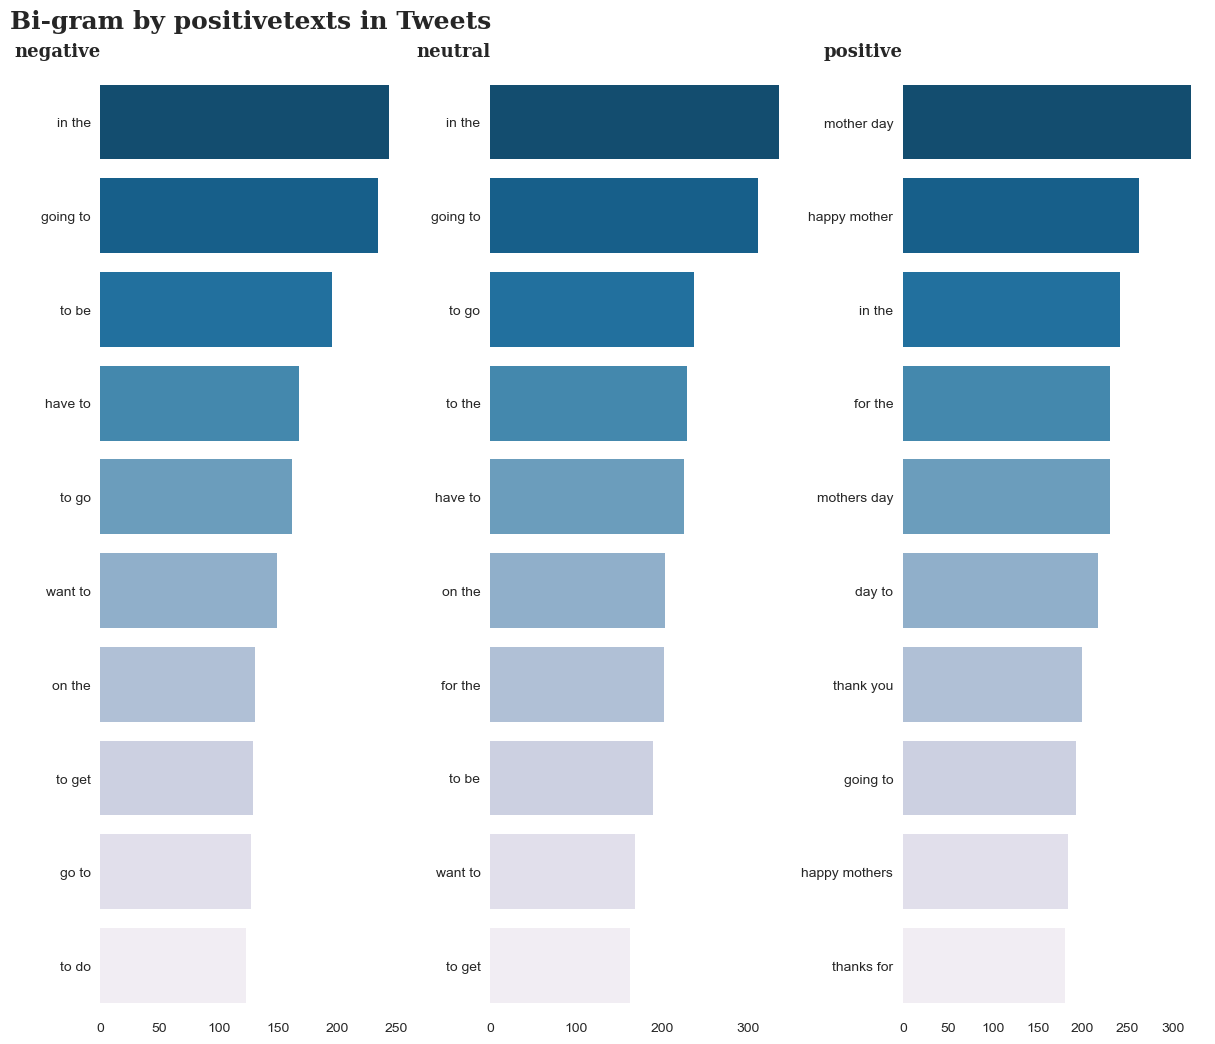

In [30]:
fig, axes = plt.subplots(1,3, figsize=(12, 10), constrained_layout=True)

sentiment_list = list(np.unique(train_df['sentiment']))

for i, sentiment in zip(range(3), sentiment_list):
    top_tweet_bigrams = get_top_tweet_bigrams(train_df[train_df['sentiment']==sentiment]['text'].fillna(" "))[:10]
    x,y = map(list,zip(*top_tweet_bigrams))
    sns.barplot(x=y, y=x, ax=axes[i], palette=PuBu_palette[::-1])
    axes[i].text(0,-0.7, sentiment, fontweight="bold", fontfamily='serif', fontsize=13,ha="right")
    axes[i].patch.set_alpha(0)

fig.text(0,1.01,"Bi-gram by {}texts in Tweets".format(sentiment), fontweight="bold", fontfamily='serif', fontsize=18)
plt.show()

In [31]:
train_df_before_drop_shape = train_df.shape
test_df_before_drop_shape = test_df.shape

In [32]:
train_df.dropna(inplace=True)
test_df.dropna(inplace=True)

In [33]:
train_df.drop(['length_alphabets','length_words'], axis=1, inplace=True)

In [34]:
train_df_drop_shape = train_df.shape
test_df_drop_shape = test_df.shape

print("Train dataset Shape : {} => {}".format(train_df_before_drop_shape, train_df_drop_shape))
print("Test dataset Shape : {} => {}".format(test_df_before_drop_shape, test_df_drop_shape))

Train dataset Shape : (27481, 6) => (27480, 4)
Test dataset Shape : (3534, 3) => (3534, 3)


In [35]:
def preprocess_fn(text):
    text = str(text)
    text = text.lower()  # lowercase

    text = re.sub(r'[!]+', '!', text)
    text = re.sub(r'[?]+', '?', text)
    text = re.sub(r'[.]+', '.', text)
    text = re.sub(r"'", "", text)
    text = re.sub('\s+', ' ', text).strip()  # Remove and double spaces
    text = re.sub(r'&amp;?', r'and', text)  # replace & -> and
    # remove some puncts (except . ! # ? *)
    text = re.sub(r'[:"$%&\+,-/:;<=>@\\^_{|}~`]+', '', text)
    emoji_pattern = re.compile("["
                               u"\U0001F600-\U0001F64F"  # emoticons
                               u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                               u"\U0001F680-\U0001F6FF"  # transport & map symbols
                               u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                               u"\U00002702-\U000027B0"
                               u"\U000024C2-\U0001F251"
                               "]+", flags=re.UNICODE)
    text = emoji_pattern.sub(r'EMOJI', text)
    
    return text

In [36]:
train_df['text'] = train_df['text'].apply(lambda x: preprocess_fn(x))
train_df['selected_text'] = train_df['selected_text'].apply(lambda x: preprocess_fn(x))

test_df['text'] = test_df['text'].apply(lambda x: preprocess_fn(x))

In [37]:
train_df.head()

,textID,text,selected_text,sentiment
0,cb774db0d1,id have responded if i were going,id have responded if i were going,neutral
1,549e992a42,sooo sad i will miss you here in san diego!,sooo sad,negative
2,088c60f138,my boss is bullying me,bullying me,negative
3,9642c003ef,what interview! leave me alone,leave me alone,negative
4,358bd9e861,sons of **** why couldnt they put them on the ...,sons of ****,negative


In [38]:
mask_dir = np.array(Image.open('./input/masks/twitter_mask3.jpg'))

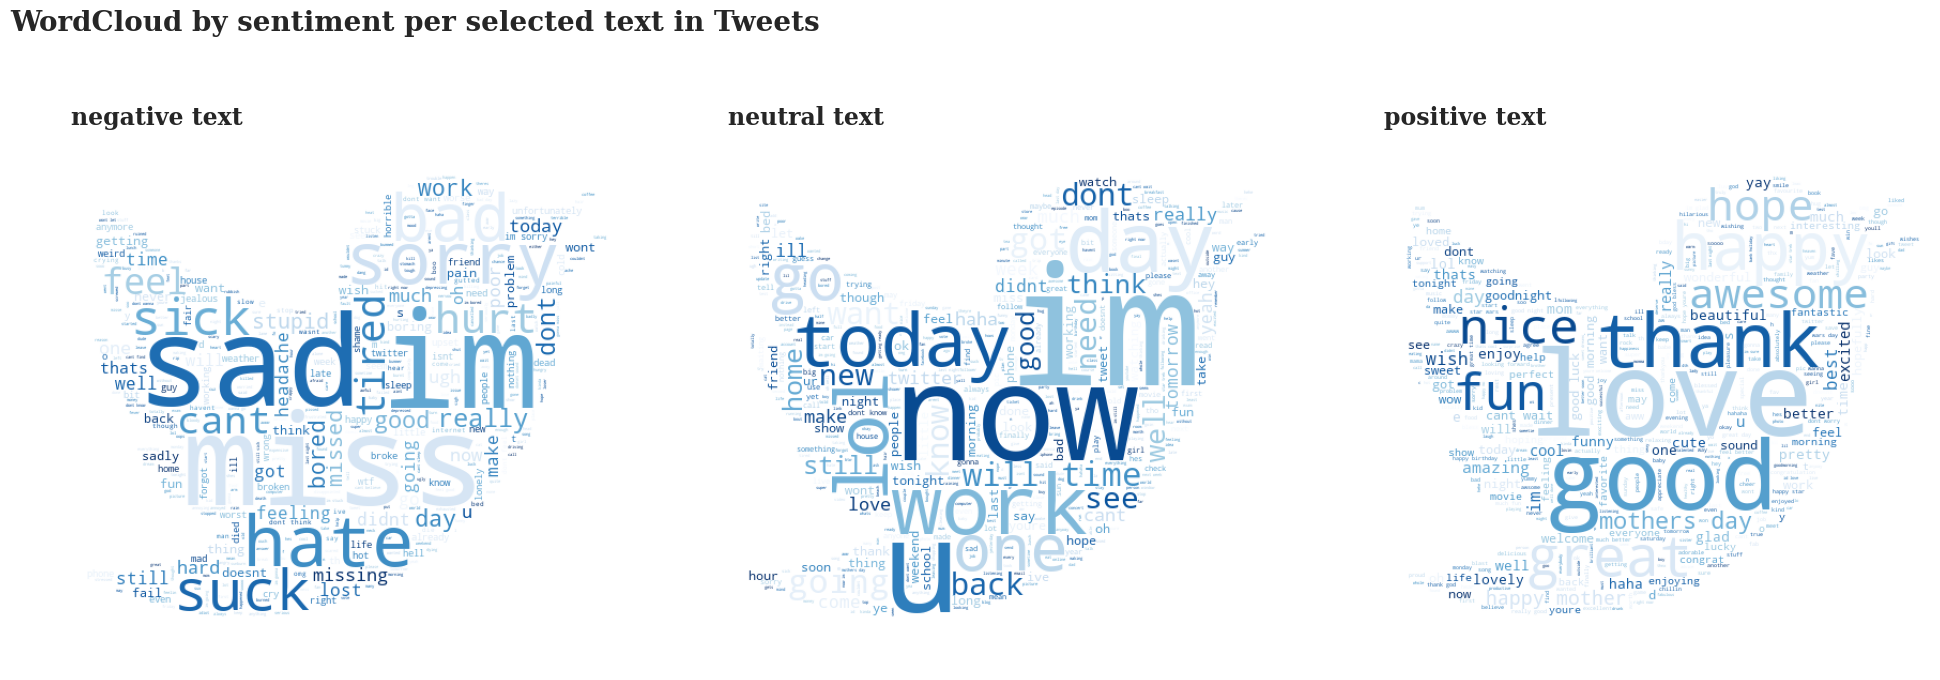

In [39]:
fig, axes = plt.subplots(1,3, figsize=(24,12))
sentiment_list = np.unique(train_df['sentiment'])

for i, sentiment in zip(range(3), sentiment_list):
    wc = WordCloud(background_color="white", max_words = 2000, width = 1600, height = 800, mask=mask_dir, colormap="Blues").generate(" ".join(train_df[train_df['sentiment']==sentiment]['selected_text']))
    
    axes[i].text(0.5,1, "{} text".format(sentiment), fontweight="bold", fontfamily='serif', fontsize=17)
    axes[i].patch.set_alpha(0)
    axes[i].axis('off')
    axes[i].imshow(wc)

fig.text(0.1,0.8,"WordCloud by sentiment per selected text in Tweets", fontweight="bold", fontfamily='serif', fontsize=20)
plt.show()

In [40]:
train_df = pd.read_csv('./input/train.csv')
test_df = pd.read_csv('./input/test.csv')

train_df.dropna(inplace=True)
test_df.dropna(inplace=True)

train_df.head()

,textID,text,selected_text,sentiment
0,cb774db0d1,"I`d have responded, if I were going","I`d have responded, if I were going",neutral
1,549e992a42,Sooo SAD I will miss you here in San Diego!!!,Sooo SAD,negative
2,088c60f138,my boss is bullying me...,bullying me,negative
3,9642c003ef,what interview! leave me alone,leave me alone,negative
4,358bd9e861,"Sons of ****, why couldn`t they put them on t...","Sons of ****,",negative


In [41]:
bert_tokenizer = BertTokenizer.from_pretrained(
    './bert_base_uncased/vocab.txt',
    do_lower_case=True)

In [42]:
print("Original Text")
print(train_df['text'][0]) # original sentence
print("\n")

print("Original Text Data")
print(bert_tokenizer.tokenize(train_df['text'][0]))
print(bert_tokenizer.convert_tokens_to_ids(bert_tokenizer.tokenize(train_df['text'][0])))
print(bert_tokenizer.decode(bert_tokenizer.convert_tokens_to_ids(bert_tokenizer.tokenize(train_df['text'][0]))))
print("\n")

print("Selcted Text Data")
print(bert_tokenizer.tokenize(train_df['selected_text'][0]))
print(bert_tokenizer.convert_tokens_to_ids(bert_tokenizer.tokenize(train_df['selected_text'][0])))
print(bert_tokenizer.decode(bert_tokenizer.convert_tokens_to_ids(bert_tokenizer.tokenize(train_df['selected_text'][0]))))

Original Text
 I`d have responded, if I were going


Original Text Data
['i', '`', 'd', 'have', 'responded', ',', 'if', 'i', 'were', 'going']
[1045, 1036, 1040, 2031, 5838, 1010, 2065, 1045, 2020, 2183]
i ` d have responded, if i were going


Selcted Text Data
['i', '`', 'd', 'have', 'responded', ',', 'if', 'i', 'were', 'going']
[1045, 1036, 1040, 2031, 5838, 1010, 2065, 1045, 2020, 2183]
i ` d have responded, if i were going


In [43]:
def get_max_len(df):
    max_len = 0
    for text in df['text']:

        # Tokenize the text and add special tokens i.e `[CLS]` and `[SEP]`
        input_ids = bert_tokenizer.encode(text, add_special_tokens=True)
        # Update the maximum sentence length.
        max_len = max(max_len, len(input_ids))

    return max_len

In [44]:
max_len = get_max_len(train_df)
print("max len : ", max_len)

max len :  110


In [45]:
class BertDataset(torch.utils.data.Dataset):
    def __init__(self, df, max_len=max_len, is_label=False):
        self.df = df
        self.max_len = max_len + 3 # 3 means `[CLS]` and sentiment and `[SEP]`
        self.is_label = is_label

        
    def __len__(self):
        return len(self.df)
    

    def __getitem__(self, index):
        global data
        data = {}
        row = self.df.iloc[index]

        ids, masks, token_type  = self.get_bert_tokenize(row)
        data['input_ids'] = ids
        data['attention_masks'] = masks
        data['token_type_ids'] = token_type
        
        # Text / Selected Text Decode
        data['text'] = bert_tokenizer.decode(ids)
        
        if self.is_label:
            start_idx, end_idx = self.get_label_idx(data, row)
            data['start_index'] = start_idx
            data['end_index'] = end_idx
             
        return data

        
    def get_label_idx(self, data, row):
        # get lavel ids
        global start_index
        global end_index
        
        text_id = bert_tokenizer.encode(
                row['selected_text'],
                add_special_tokens=False,
            )
        label_len = len(text_id)
            
        # get start index / end index        
        for i in range(self.max_len):
            if data['input_ids'][i] == text_id[0]:
                if data['input_ids'][i+label_len-1] == text_id[-1]:
                    start_index = i
                    end_index = i+label_len-1
                    break

        return torch.tensor(start_index), torch.tensor(end_index)
    
    
    def get_bert_tokenize(self, row):
        
        text = row['text']
        sentiment = row['sentiment']
        
        encoded = bert_tokenizer.encode_plus(
          sentiment,
          text,
          add_special_tokens=True,
          max_length=self.max_len,
          pad_to_max_length=True,
          return_token_type_ids=True,
          return_attention_mask=True,
          return_tensors='pt'
        )

        input_ids = encoded['input_ids'].squeeze()
        attention_masks = encoded['attention_mask'].squeeze()
        token_type_ids = encoded['token_type_ids'].squeeze()
        
        return input_ids, attention_masks, token_type_ids  

In [46]:
train_df, val_df = train_test_split(train_df, test_size=0.2)
print("Train dataframe size:",train_df.shape)
print("Validation dataframe size:",val_df.shape)

Train dataframe size: (21984, 4)
Validation dataframe size: (5496, 4)


In [47]:
train_dataset = BertDataset(train_df, is_label=True)
val_dataset = BertDataset(val_df, is_label=True)
test_dataset = BertDataset(test_df, is_label=False)

In [48]:
print("Original text length: {} \n".format(len(train_dataset[0]['input_ids'])))
print("Original text: {} \n\n".format(train_dataset[0]['text']))

print("[input_ids] \n", train_dataset[0]['input_ids'])
print("\n[attention_masks] \n", train_dataset[0]['attention_masks'])
print("\n[token_type_ids] \n", train_dataset[0]['token_type_ids'])

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


Original text length: 113 

Original text: [CLS] negative [SEP] bad hair day [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] 


[input_ids] 
 tensor([ 101, 4997,  102, 2919, 2606, 2154,  102,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0

In [49]:
def get_train_val_loaders(train_dataset, val_dataset, batch_size=8):
    
    train_loader = torch.utils.data.DataLoader(
        train_dataset,
        batch_size=8, 
        shuffle=True, 
        num_workers=0,
        drop_last=True)
    
    val_loader = torch.utils.data.DataLoader(
        val_dataset,
        batch_size=batch_size, 
        shuffle=False, 
        num_workers=0)
    
    dataloaders_dict = {"train": train_loader, "val": val_loader}
    return dataloaders_dict


def get_test_loader(dataset, batch_size=32):
    
    loader = torch.utils.data.DataLoader(
        dataset,
        batch_size=batch_size, 
        shuffle=False, 
        num_workers=0)  
    
    return loader

In [50]:
dict_loader = get_train_val_loaders(train_dataset, val_dataset)
test_loader = get_test_loader(test_dataset)

In [51]:
dict_loader

{'train': <torch.utils.data.dataloader.DataLoader at 0x1fc8bfc4d30>,
 'val': <torch.utils.data.dataloader.DataLoader at 0x1fc8bfc5990>}

In [52]:
USE_CUDA = torch.cuda.is_available() 
print(USE_CUDA)

device = torch.device('cuda:0' if USE_CUDA else 'cpu') 
print('A device that proceeds with : ',device)

True
A device that proceeds with :  cuda:0


In [53]:
## main ##
class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        config = BertConfig.from_pretrained(
            './bert_base_uncased/config.json', output_hidden_states=True)    
        self.bert = transformers.BertModel.from_pretrained(
            './bert_base_uncased/pytorch_model.bin', config=config)
        self.hidden_size = self.bert.config.hidden_size
        self.LSTM = nn.LSTM(self.hidden_size*2, 128)
        self.layer = nn.Sequential(
            nn.Linear(128,64),
            nn.Dropout(0.2),
        )
    
        # The output will have two dimensions ("start_logits", and "end_logits")
        self.FC = nn.Linear(64,2)
        torch.nn.init.normal_(self.FC.weight, std=0.02)
        
 
    def forward(self, ids, mask, token):
        # Return the hidden states from the BERT backbone
        out = self.bert(
            ids,
            attention_mask=mask,
            token_type_ids=token
        )
        
        out = torch.cat((out[2][-1],out[2][-2]), dim=-1)
        
        out, _ = self.LSTM(out)
        out = self.layer(out)
        logits = self.FC(out)
        start_logits, end_logits = logits.split(1, dim=-1)
        start_logits = start_logits.squeeze(-1)
        end_logits = end_logits.squeeze(-1)

        return start_logits, end_logits

In [54]:
def loss_fn(start_logits, end_logits, start_positions, end_positions):
    ce_loss = nn.CrossEntropyLoss()
    start_loss = ce_loss(start_logits, start_positions)
    end_loss = ce_loss(end_logits, end_positions)    
    total_loss = start_loss + end_loss
    return total_loss

In [55]:
def get_selected_text(text_encode, start_idx, end_idx):
    text_encode = text_encode[start_idx: end_idx + 1]
    selected_text = bert_tokenizer.decode(text_encode)
    return selected_text


def get_original_text(text_encode):
    text_encode = text_encode[3:]
    for i, encode in enumerate(text_encode):
        if encode == 102:
            last_index = i
            break
    return bert_tokenizer.decode(text_encode[:last_index])
    
       
def jaccard(str1, str2): 
    a = set(str1.lower().split()) 
    b = set(str2.lower().split())
    c = a.intersection(b)
    return float(len(c)) / (len(a) + len(b) - len(c))


def compute_jaccard_score(text_encode, start_idx, end_idx, start_logits, end_logits):
    start_pred = np.argmax(start_logits)
    end_pred = np.argmax(end_logits)
    # print("start predict index : {} / end predict index : {}".format(start_pred, end_pred))
    # print("start real index : {} / end real index : {}".format(start_idx, end_idx))
    # print(text_encode)
    
    if start_pred > end_pred:
        pred = get_original_text(text_encode)
        # print("get original text", pred)
    else:
        pred = get_selected_text(text_encode, start_pred, end_pred)
        # print("get selected text : ",pred)
        
    true = get_selected_text(text_encode, start_idx, end_idx)
    # print("get label text : ",true)
    return jaccard(true, pred)

In [56]:
def train_model(model, dataloaders_dict, criterion, optimizer, num_epochs, filename):
    model.to(device)

    for epoch in range(num_epochs):
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
            else:
                model.eval()

            epoch_loss = 0.0
            epoch_jaccard = 0.0
            
            for j, data in enumerate((dataloaders_dict[phase])):
                ids = data['input_ids'].to(device, dtype=torch.int64)
                masks = data['attention_masks'].to(device, dtype=torch.int64)
                token = data['token_type_ids'].to(device, dtype=torch.int64)
                start_idx = data['start_index'].to(device, dtype=torch.int64)
                end_idx = data['end_index'].to(device, dtype=torch.int64)

                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    
                    start_logits, end_logits = model(ids, masks, token)
                    
                    loss = criterion(start_logits, end_logits, start_idx, end_idx)
                    
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                    epoch_loss += loss.item() * len(ids)
                    
                    start_idx = start_idx.cpu().detach().numpy()
                    end_idx = end_idx.cpu().detach().numpy()
                    start_logits = torch.softmax(start_logits, dim=1).cpu().detach().numpy()
                    end_logits = torch.softmax(end_logits, dim=1).cpu().detach().numpy()
                    
                    
                    for i in range(len(ids)):                        
                        jaccard_score = compute_jaccard_score(
                            ids[i],
                            start_idx[i],#인코딩 후
                            end_idx[i],
                            start_logits[i], #인코딩 후
                            end_logits[i])
                        epoch_jaccard += jaccard_score
                    
            epoch_loss = epoch_loss / len(dataloaders_dict[phase].dataset)
            epoch_jaccard = epoch_jaccard / len(dataloaders_dict[phase].dataset)
            
            print('Epoch {}/{} | {:^5} | Loss: {:.4f} | Jaccard: {:.4f}'.format(
                epoch + 1, num_epochs, phase, epoch_loss, epoch_jaccard))
    
    torch.save(model.state_dict(), SAVE_MODEL_PATH)

In [57]:
import gc
gc.collect()
torch.cuda.empty_cache()

In [58]:
EPOCHS = 3
SAVE_MODEL_PATH = f'bert.pth'

In [59]:
model = Model() 
optimizer = optim.AdamW(model.parameters(), lr=3e-5, betas=(0.9, 0.999))
criterion = loss_fn

train_model(
    model, 
    dict_loader,
    criterion, 
    optimizer, 
    EPOCHS,
    SAVE_MODEL_PATH)

Epoch 1/3 | train | Loss: 2.7611 | Jaccard: 0.6199
Epoch 1/3 |  val  | Loss: 2.0489 | Jaccard: 0.6640
Epoch 2/3 | train | Loss: 1.8060 | Jaccard: 0.7003
Epoch 2/3 |  val  | Loss: 2.0084 | Jaccard: 0.6853
Epoch 3/3 | train | Loss: 1.4938 | Jaccard: 0.7459
Epoch 3/3 |  val  | Loss: 2.0535 | Jaccard: 0.6806


In [60]:
predictions = []

model = Model()
model.cuda()
model.load_state_dict(torch.load(f'bert.pth'))
model.eval()


for data in test_loader:
    ids = data['input_ids'].to(device, dtype=torch.int64)
    masks = data['attention_masks'].to(device, dtype=torch.int64)
    token = data['token_type_ids'].to(device, dtype=torch.int64)
                                          
    start_logits = []
    end_logits = []
    with torch.no_grad():
        start_logit, end_logit = model(ids, masks, token)
        start_logits = torch.softmax(start_logit, dim=1).cpu().detach().numpy()
        end_logits = torch.softmax(end_logit, dim=1).cpu().detach().numpy()
    
    for i in range(len(ids)):    
        start_pred = np.argmax(start_logits[i])
        end_pred = np.argmax(end_logits[i])
        if start_pred > end_pred:
            pred = get_original_text(ids[i])
        else:
            pred = get_selected_text(ids[i], start_pred, end_pred)
        predictions.append(pred)

In [61]:
test_df.head()

,textID,text,sentiment
0,f87dea47db,Last session of the day http://twitpic.com/67ezh,neutral
1,96d74cb729,Shanghai is also really exciting (precisely -...,positive
2,eee518ae67,"Recession hit Veronique Branquinho, she has to...",negative
3,01082688c6,happy bday!,positive
4,33987a8ee5,http://twitpic.com/4w75p - I like it!!,positive


In [62]:
print("[Predicton head]")
for i,pred in enumerate(predictions[:5]):
    print("index",i,": ",pred)

[Predicton head]
index 0 :  last session of the day
index 1 :  shanghai is also really exciting
index 2 :  shame!
index 3 :  happy bday!
index 4 :  i like


In [63]:
submission = pd.read_csv('./input/sample_submission.csv')
submission['selected_text'] = predictions
submission.head()

,textID,selected_text
0,f87dea47db,last session of the day
1,96d74cb729,shanghai is also really exciting
2,eee518ae67,shame!
3,01082688c6,happy bday!
4,33987a8ee5,i like


In [64]:
submission.to_csv('submission.csv', index=False)